In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
boston_data = load_boston()
X = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
y = pd.DataFrame(boston_data.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
def eval_metrics(model, X_train, y_train, y_predict_train, X_test, y_test, y_predict, eval_metrics_dict):
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    
    mse_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
    mse_test = np.sqrt(mean_squared_error(y_test, y_predict))
    
    eval_metrics_dict['r2_train'].append(r2_train)
    eval_metrics_dict['r2_test'].append(r2_test)
    eval_metrics_dict['mse_train'].append(mse_train)
    eval_metrics_dict['mse_test'].append(mse_test)
    
    return eval_metrics_dict

In [5]:
def plot_eval_metrics(degrees_range, eval_metrics_dict):
    
    with sns.axes_style('darkgrid'):
        plt.subplot(121)
        plt.tight_layout()
        plt.plot(degrees_range, eval_metrics_dict['r2_train'], color='blue')
        plt.plot(degrees_range, eval_metrics_dict['r2_test'], color='red')
        plt.title('R^2')
        
        plt.subplot(122)
        plt.tight_layout()
        plt.plot(degrees_range, eval_metrics_dict['mse_train'], color='blue')
        plt.plot(degrees_range, eval_metrics_dict['mse_test'], color='red')
        plt.title('MSE')

In [6]:
def linear_regression(model, max_degrees):
    
    result = {
        'r2_train': [],
        'r2_test': [],
        'mse_train': [],
        'mse_test': [],
    }
    
    for degree in range(1, max_degrees + 1):
        model_p = make_pipeline(PolynomialFeatures(degree, interaction_only=False), model)
        model_p.fit(X_train, y_train)
        
        y_predict_train = model_p.predict(X_train)
        y_predict = model_p.predict(X_test)
        
        result = eval_metrics(model_p, X_train, y_train, y_predict_train, X_test, y_test, y_predict, result)
        
    return result
        

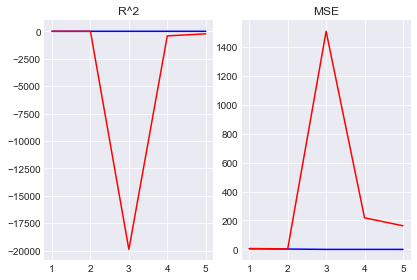

In [81]:
max_degrees = 5
degrees_range = np.arange(1, max_degrees + 1)

# linear regression with regularization
lm = LinearRegression()

eval_metrics_dict = linear_regression(lm, max_degrees)
plot_eval_metrics(degrees_range, eval_metrics_dict)

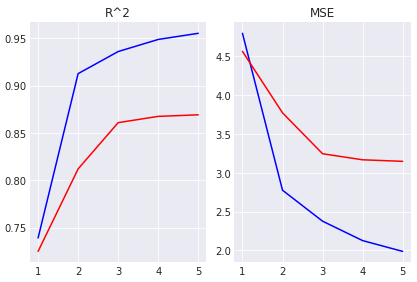

In [7]:
max_degrees = 5
degrees_range = np.arange(1, max_degrees + 1)

# linear regression with Lasso
lm = Lasso(alpha=0.001, max_iter=1000, normalize=True)

eval_metrics_dict = linear_regression(lm, max_degrees)
plot_eval_metrics(degrees_range, eval_metrics_dict)

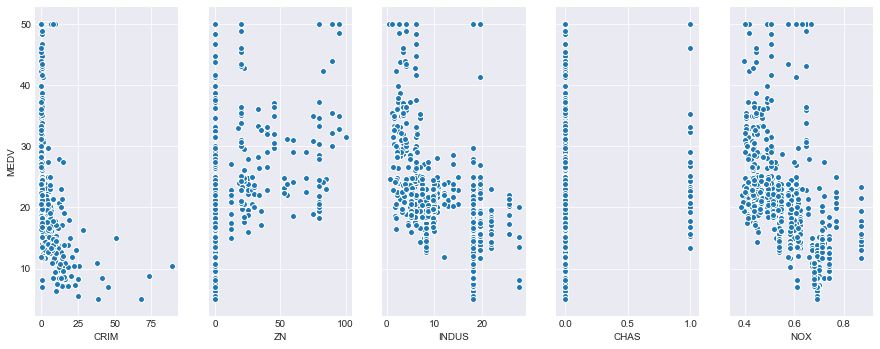

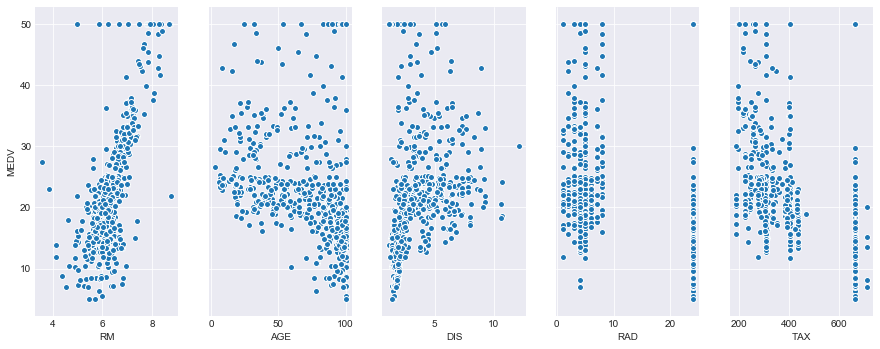

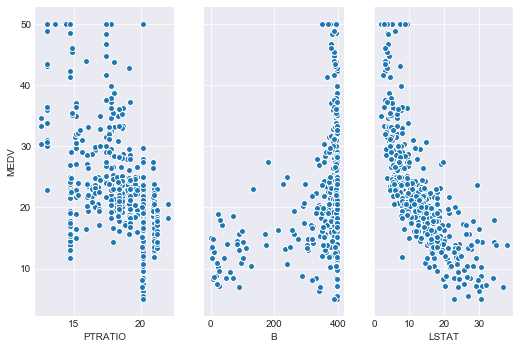

In [76]:
t = X.join(y)

with sns.axes_style('darkgrid'):
    sns.pairplot(t, x_vars=X.keys()[:5], y_vars=y.keys(), size=5, aspect=0.5)
    sns.pairplot(t, x_vars=X.keys()[5:10], y_vars=y.keys(), size=5, aspect=0.5)
    sns.pairplot(t, x_vars=X.keys()[10:14], y_vars=y.keys(), size=5, aspect=0.5)

#### Experiments with Cross Validation

Train score: 0.9160731797513989 
 Test Score: 0.7976135376613565 
 alpha: 0.0007896522868499724


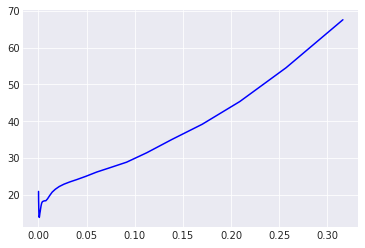

In [8]:
lasso_eps = 0.0001
lasso_iter=5000
alphas = np.logspace(-4, -0.5, 40)

lm_lasso = LassoCV(eps=lasso_eps, alphas=alphas, max_iter=lasso_iter, normalize=True, cv=10)

lasso_p = make_pipeline(PolynomialFeatures(2, interaction_only=False), lm_lasso)
lasso_p.fit(X_train, y_train.values.ravel())

lm_lasso_score = lasso_p.score(X_train, y_train.values.ravel())
lm_lasso_score_test = lasso_p.score(X_test, y_test.values.ravel())

print(f'Train score: {lm_lasso_score} \n Test Score: {lm_lasso_score_test} \n alpha: {lm_lasso.alpha_}')
mse_mean = np.mean(lm_lasso.mse_path_, axis=1)

with sns.axes_style('darkgrid'):
    plt.plot(lm_lasso.alphas_, mse_mean, color='blue')




In [4]:

def run_polynomial_grid_pipeline(X_train, y_train, X_test, y_test):

    steps = [
        ('poly', PolynomialFeatures()),
        ('regr', Lasso())
    ]
    pipeline = Pipeline(steps)
    
    parameters = {
        'poly__degree': [2, 3],
        'regr__alpha': np.logspace(-4, -0.5, 40)
    }
    
    grid = GridSearchCV(pipeline, param_grid=parameters, cv=10, n_jobs=-1)
    grid.fit(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    
    print(grid.best_score_)
    print(grid.best_params_)
    print(test_score)


In [5]:
num_features = 9
test = SelectKBest(score_func=f_regression, k=num_features)
k_best = test.fit(X_train, y_train.values.ravel())

score = k_best.scores_
new_X = k_best.transform(X)

features = boston_data.feature_names
d = dict(zip(features, score))

print(f'New Features Matrix Size:\t{new_X.shape} \nOriginal Features Matrix Size: \t{X.shape}')

New Features Matrix Size:	(506, 9) 
Original Features Matrix Size: 	(506, 13)


In [ ]:
print('Running for all features...')
run_polynomial_grid_pipeline(X_train, y_train, X_test, y_test)

print(f'\nRunning for {num_features} main features...')
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.33, random_state=42)
run_polynomial_grid_pipeline(new_X_train, new_y_train, new_X_test, new_y_test)






Running for all features...


Process ForkPoolWorker-11:


Process ForkPoolWorker-9:


Process ForkPoolWorker-12:


Process ForkPoolWorker-10:


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


Traceback (most recent call last):


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()


  File "/Users/pankajk/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()


  File "/Users/pankajk/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()


  File "/Users/pankajk/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()


  File "/Users/pankajk/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()


KeyboardInterrupt


KeyboardInterrupt


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()


KeyboardInterrupt


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)


  File "/Users/pankajk/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


KeyboardInterrupt


KeyboardInterrupt: 